# I. Очистка и подготовка данных

**Цель:** очистить данные, обработать пропуски, избавиться от выбросов, преобразовать существующие типы данных, проверить бизнес-логику, добавить новые признаки и подготовить данные к исследовательскому анализу.

---
## 1. Импорт библиотек и загрузка данных
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
df = pd.read_csv("../data/raw/kicksharing.csv")

# Отобразим первые 5 строк, чтобы убедиться в том, что данные загрузились
df.head()

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
0,266071307,761067705,M,40,UGR,DIV,ТЮМЕНСКАЯ ОБЛ,4.99,30.0,300.0,SL,3.690479,2024-08-07 09:47:25.000000,2024-08-07 09:47:29.325252,2024-08-07 10:07:59.339524,5,2024-08-07 11:47:29.325252,134.79,19.48,NaN
1,355113920,614049469,F,30,GRD,MAR,РОСТОВСКАЯ ОБЛ,8.49,50.0,300.0,SL,1.114912,2024-10-17 14:57:20.000000,2024-10-17 14:57:24.586000,2024-10-17 15:04:19.419607,3,2024-10-17 14:57:24.586000,109.43,40.30,NaN
2,347424551,757583701,M,28,UGR,UNM,СВЕРДЛОВСКАЯ ОБЛ,5.99,30.0,300.0,E,1.515612,2024-09-19 05:31:41.000000,2024-09-19 05:34:59.476000,2024-09-19 05:41:50.164372,5,2024-09-19 07:34:59.476000,71.93,10.79,NaN
3,351562959,541367366,M,24,GRD,UNM,Г МОСКВА,8.99,50.0,300.0,SL,0.499411,2024-10-04 16:05:09.000000,2024-10-04 16:05:13.162000,2024-10-04 16:07:31.724918,3,2024-10-04 16:05:13.162000,76.97,7.70,NaN
4,258647149,238473615,M,34,NaN,NaN,Г МОСКВА,6.99,50.0,300.0,SL,2.602028,2024-07-10 06:57:40.000000,2024-07-10 06:57:43.017125,2024-07-10 07:07:48.446462,3,2024-07-10 06:57:43.017125,126.89,25.38,NaN


Данные по поездкам на самокатах загружены. Файл содержит информацию о клиентах, поездках, стоимости, регионах и характеристиках самокатов.

---
## 2. Первичный осмотр данных
---

In [3]:
print(f"- Размер датасета: {df.shape}")

print(f"\n- Типы данных:\n{df.dtypes}")

# Список колонок
print(f"\n- Названия колонок: {df.columns.tolist()}")

print(f"\n- Информация о датасете:")
print(df.info())

print(f"\n- Описание числовых признаков:\n{df.describe()}")

print(f"\n- Пропуски:\n{df.isna().sum()}")

print(f"\n- Пропусков во всем датасете: {df.isna().sum().sum()}")

print(f'\n- Дубликаты: {df.duplicated().sum()}')

- Размер датасета: (396749, 20)

- Типы данных:
order_rk                     int64
party_rk                     int64
gender_cd                   object
age                          int64
education_level_cd          object
marital_status_cd           object
lvn_state_nm                object
minute_cost                float64
activation_cost            float64
hold_amount                float64
transport_model             object
distance_km                float64
created_dttm                object
book_start_dttm             object
book_end_dttm               object
book_time_zone_cd            int64
local_book_start_dttm       object
nominal_price_rub_amt      float64
loyalty_accrual_rub_amt    float64
loyalty_accrual_bns_amt    float64
dtype: object

- Названия колонок: ['order_rk', 'party_rk', 'gender_cd', 'age', 'education_level_cd', 'marital_status_cd', 'lvn_state_nm', 'minute_cost', 'activation_cost', 'hold_amount', 'transport_model', 'distance_km', 'created_dttm', 'book_start_dt

Краткая информация о датасете:
- Всего 396749 строк, 20 колонок
- С помощью функции `describe()` найдены аномалии в `distance_km` (max-значение = 56012,640308 км)
- Неверный тип данных у дат и категориальных признаков
- Присутствуют пропуски
- Нет дубликатов

In [4]:
# Проверка на уникальность идентификаторов поездок
print(f"Количество уникальных идентификаторов: {df['order_rk'].nunique()}")

print(f"Количество записей (длина датасета): {df.shape[0]}")

df['order_rk'].nunique() == df.shape[0]

Количество уникальных идентификаторов: 396749
Количество записей (длина датасета): 396749


True

Количество уникальных идентификаторов поездок совпадает с количеством записей в датасете. Данные уникальны.

---
## 3. Преобразование типов данных
---

In [5]:
# Колонки с датами
date_columns = ['created_dttm', 'book_start_dttm', 'book_end_dttm', 'local_book_start_dttm']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Проверим тип данных
df[date_columns].dtypes

created_dttm             datetime64[ns]
book_start_dttm          datetime64[ns]
book_end_dttm            datetime64[ns]
local_book_start_dttm    datetime64[ns]
dtype: object

In [6]:
# Категориальные колонки
category_columns = ['gender_cd', 'education_level_cd', 'marital_status_cd', 'lvn_state_nm', 'transport_model']
for col in category_columns:
    df[col] = df[col].astype('category')  # Приводим к типу category

# Проверим тип данных
df[category_columns].dtypes

gender_cd             category
education_level_cd    category
marital_status_cd     category
lvn_state_nm          category
transport_model       category
dtype: object

Типы данных приведены к корректным форматам:
- даты к datetime
- категории к category

---
## 4. Обработка пропущенных значений и дубликатов
---

In [7]:
# Считаем пропуски в каждой колонке и сортируем результат по убыванию
df.isna().sum().sort_values(ascending=False)

loyalty_accrual_bns_amt    374801
education_level_cd         206690
marital_status_cd          179020
lvn_state_nm                34177
loyalty_accrual_rub_amt     29757
gender_cd                    2921
order_rk                        0
party_rk                        0
age                             0
hold_amount                     0
activation_cost                 0
minute_cost                     0
distance_km                     0
transport_model                 0
created_dttm                    0
book_start_dttm                 0
book_time_zone_cd               0
book_end_dttm                   0
nominal_price_rub_amt           0
local_book_start_dttm           0
dtype: int64

Пропуски присутствуют в 6 колонках. Необходимо обработать пропуски.

In [8]:
# Для наглядности можно представить пропуски в процентном соотношении от размера датасета
((df.isna().sum() / df.shape[0] * 100).sort_values(ascending=False)
    .to_frame(name='Процент пропусков %').style.format("{:.2f}%"))

,Процент пропусков %
loyalty_accrual_bns_amt,94.47%
education_level_cd,52.10%
marital_status_cd,45.12%
lvn_state_nm,8.61%
loyalty_accrual_rub_amt,7.50%
gender_cd,0.74%
order_rk,0.00%
party_rk,0.00%
age,0.00%
hold_amount,0.00%


На основе полученных данных обрабатывать пропуски будем следующим образом:
1. Удалим колонку с процентом пропусков > 90%
2. Заменим значение NaN / Null на 0 в колонке `loyalty_accrual_rub_amt`, которая отвечает за кэшбэк в рублях
3. Добавим категорию U / Unknown / UNK, которая будет означать, что данные не были указаны, в категориальные признаки

In [9]:
# Удаляем колонку "Размер выплаченного кэшбэка в бонусах"

df.drop(columns=['loyalty_accrual_bns_amt'], inplace=True)
df.head()

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt
0,266071307,761067705,M,40,UGR,DIV,ТЮМЕНСКАЯ ОБЛ,4.99,30.0,300.0,SL,3.690479,2024-08-07 09:47:25,2024-08-07 09:47:29.325252,2024-08-07 10:07:59.339524,5,2024-08-07 11:47:29.325252,134.79,19.48
1,355113920,614049469,F,30,GRD,MAR,РОСТОВСКАЯ ОБЛ,8.49,50.0,300.0,SL,1.114912,2024-10-17 14:57:20,2024-10-17 14:57:24.586000,2024-10-17 15:04:19.419607,3,2024-10-17 14:57:24.586000,109.43,40.30
2,347424551,757583701,M,28,UGR,UNM,СВЕРДЛОВСКАЯ ОБЛ,5.99,30.0,300.0,E,1.515612,2024-09-19 05:31:41,2024-09-19 05:34:59.476000,2024-09-19 05:41:50.164372,5,2024-09-19 07:34:59.476000,71.93,10.79
3,351562959,541367366,M,24,GRD,UNM,Г МОСКВА,8.99,50.0,300.0,SL,0.499411,2024-10-04 16:05:09,2024-10-04 16:05:13.162000,2024-10-04 16:07:31.724918,3,2024-10-04 16:05:13.162000,76.97,7.70
4,258647149,238473615,M,34,NaN,NaN,Г МОСКВА,6.99,50.0,300.0,SL,2.602028,2024-07-10 06:57:40,2024-07-10 06:57:43.017125,2024-07-10 07:07:48.446462,3,2024-07-10 06:57:43.017125,126.89,25.38


In [10]:
# Заполняем нулями пропуски в колонке "Размер выплаченного кэшбэка в рублях"

df['loyalty_accrual_rub_amt'] = df['loyalty_accrual_rub_amt'].fillna(0)
df.head(10)

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt
0,266071307,761067705,M,40,UGR,DIV,ТЮМЕНСКАЯ ОБЛ,4.99,30.0,300.0,SL,3.690479,2024-08-07 09:47:25,2024-08-07 09:47:29.325252,2024-08-07 10:07:59.339524,5,2024-08-07 11:47:29.325252,134.79,19.48
1,355113920,614049469,F,30,GRD,MAR,РОСТОВСКАЯ ОБЛ,8.49,50.0,300.0,SL,1.114912,2024-10-17 14:57:20,2024-10-17 14:57:24.586000,2024-10-17 15:04:19.419607,3,2024-10-17 14:57:24.586000,109.43,40.30
2,347424551,757583701,M,28,UGR,UNM,СВЕРДЛОВСКАЯ ОБЛ,5.99,30.0,300.0,E,1.515612,2024-09-19 05:31:41,2024-09-19 05:34:59.476000,2024-09-19 05:41:50.164372,5,2024-09-19 07:34:59.476000,71.93,10.79
3,351562959,541367366,M,24,GRD,UNM,Г МОСКВА,8.99,50.0,300.0,SL,0.499411,2024-10-04 16:05:09,2024-10-04 16:05:13.162000,2024-10-04 16:07:31.724918,3,2024-10-04 16:05:13.162000,76.97,7.70
4,258647149,238473615,M,34,NaN,NaN,Г МОСКВА,6.99,50.0,300.0,SL,2.602028,2024-07-10 06:57:40,2024-07-10 06:57:43.017125,2024-07-10 07:07:48.446462,3,2024-07-10 06:57:43.017125,126.89,25.38
5,277397094,5247768,M,42,NaN,NaN,МОСКВА,7.49,50.0,300.0,SL,0.016090,2024-09-10 09:40:18,2024-09-10 09:40:24.036000,2024-09-10 09:41:03.644495,3,2024-09-10 09:40:24.036000,0.00,0.00
6,273528957,801272780,F,19,NaN,NaN,РЕСП ТАТАРСТАН,7.49,30.0,300.0,SL,4.086853,2024-09-03 14:10:29,2024-09-03 14:10:34.524349,2024-09-03 14:21:25.119585,3,2024-09-03 14:10:34.524349,112.39,28.00
7,265062394,866880584,M,38,NaN,NaN,СВЕРДЛОВСКАЯ ОБЛ,5.99,30.0,300.0,E,2.370597,2024-08-03 03:09:35,2024-08-03 03:09:38.493851,2024-08-03 03:18:47.841493,5,2024-08-03 05:09:38.493851,89.90,12.99
8,351562880,762053500,M,19,NaN,NaN,НОВОСИБИРСКАЯ ОБЛ,5.99,30.0,300.0,E,0.101272,2024-10-04 10:45:16,2024-10-04 10:45:20.457000,2024-10-04 10:47:39.863967,7,2024-10-04 14:45:20.457000,47.97,4.80
9,269365210,161703813,M,31,UGR,MAR,ЧЕЛЯБИНСКАЯ ОБЛ,6.49,30.0,300.0,E,1.487792,2024-08-19 14:35:17,2024-08-19 14:35:20.199325,2024-08-19 14:42:53.835731,5,2024-08-19 16:35:20.199325,81.92,81.92


In [11]:
# Добавляем новую категорию 'U' для пола
df['gender_cd'] = df['gender_cd'].cat.add_categories('U')

# Заполняем пропуски новой категорией
df['gender_cd'] = df['gender_cd'].fillna('U')

# Проверяем добавление новой категории
df.query("gender_cd == 'U'").head()

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt
195,266870060,1070203402,U,20,NaN,NaN,КРАСНОДАРСКИЙ КРАЙ,4.99,35.0,300.0,Max,2.265300,2024-08-10 19:15:37,2024-08-10 19:15:40.122400,2024-08-10 19:25:34.953775,3,2024-08-10 19:15:40.122400,84.90,8.49
260,348290215,1169099402,U,30,NaN,NaN,МОСКОВСКАЯ ОБЛ,7.99,50.0,300.0,SL,0.362538,2024-09-22 16:27:20,2024-09-22 16:27:26.707000,2024-09-22 16:31:50.847951,3,2024-09-22 16:27:26.707000,89.95,9.00
268,267911637,852599286,U,49,NaN,NaN,МОСКОВСКАЯ ОБЛ,6.99,50.0,300.0,SL,0.384341,2024-08-14 18:32:20,2024-08-14 18:32:24.694067,2024-08-14 18:34:52.532171,3,2024-08-14 18:32:24.694067,70.97,7.10
286,269622236,1169099402,U,30,NaN,NaN,МОСКОВСКАЯ ОБЛ,5.99,50.0,300.0,Urban E-Bike,1.062598,2024-08-20 05:07:25,2024-08-20 05:07:35.257254,2024-08-20 05:11:53.047628,3,2024-08-20 05:07:35.257254,79.95,8.00
532,348029939,1028749312,U,23,NaN,NaN,Г МОСКВА,6.96,50.0,300.0,SL,3.659932,2024-09-21 07:59:02,2024-09-21 07:59:06.205000,2024-09-21 08:19:35.249676,3,2024-09-21 07:59:06.205000,196.16,58.85


In [12]:
# Добавляем новую категорию 'Unknown' для оставшихся категориальных признаков
category_columns = ['education_level_cd', 'marital_status_cd', 'lvn_state_nm']
for col in category_columns:
    df[col] = df[col].cat.add_categories('Unknown')
    df[col] = df[col].fillna('Unknown')

df.head()

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt
0,266071307,761067705,M,40,UGR,DIV,ТЮМЕНСКАЯ ОБЛ,4.99,30.0,300.0,SL,3.690479,2024-08-07 09:47:25,2024-08-07 09:47:29.325252,2024-08-07 10:07:59.339524,5,2024-08-07 11:47:29.325252,134.79,19.48
1,355113920,614049469,F,30,GRD,MAR,РОСТОВСКАЯ ОБЛ,8.49,50.0,300.0,SL,1.114912,2024-10-17 14:57:20,2024-10-17 14:57:24.586000,2024-10-17 15:04:19.419607,3,2024-10-17 14:57:24.586000,109.43,40.30
2,347424551,757583701,M,28,UGR,UNM,СВЕРДЛОВСКАЯ ОБЛ,5.99,30.0,300.0,E,1.515612,2024-09-19 05:31:41,2024-09-19 05:34:59.476000,2024-09-19 05:41:50.164372,5,2024-09-19 07:34:59.476000,71.93,10.79
3,351562959,541367366,M,24,GRD,UNM,Г МОСКВА,8.99,50.0,300.0,SL,0.499411,2024-10-04 16:05:09,2024-10-04 16:05:13.162000,2024-10-04 16:07:31.724918,3,2024-10-04 16:05:13.162000,76.97,7.70
4,258647149,238473615,M,34,Unknown,Unknown,Г МОСКВА,6.99,50.0,300.0,SL,2.602028,2024-07-10 06:57:40,2024-07-10 06:57:43.017125,2024-07-10 07:07:48.446462,3,2024-07-10 06:57:43.017125,126.89,25.38


In [13]:
df.isna().sum().sort_values(ascending=False)

order_rk                   0
party_rk                   0
gender_cd                  0
age                        0
education_level_cd         0
marital_status_cd          0
lvn_state_nm               0
minute_cost                0
activation_cost            0
hold_amount                0
transport_model            0
distance_km                0
created_dttm               0
book_start_dttm            0
book_end_dttm              0
book_time_zone_cd          0
local_book_start_dttm      0
nominal_price_rub_amt      0
loyalty_accrual_rub_amt    0
dtype: int64

Успешно обработали пропущенные значения.

---
## 5. Логическая фильтрация и очистка от выбросов
---

distance_km:

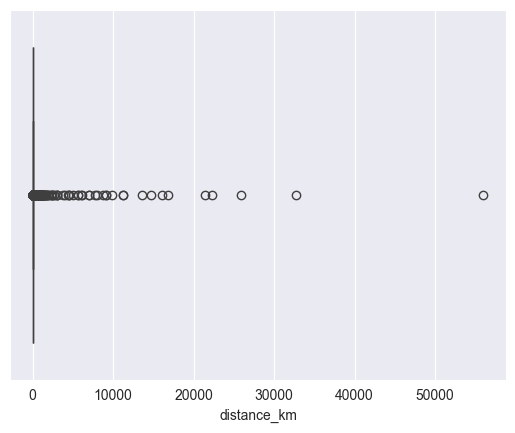

nominal_price_rub_amt:

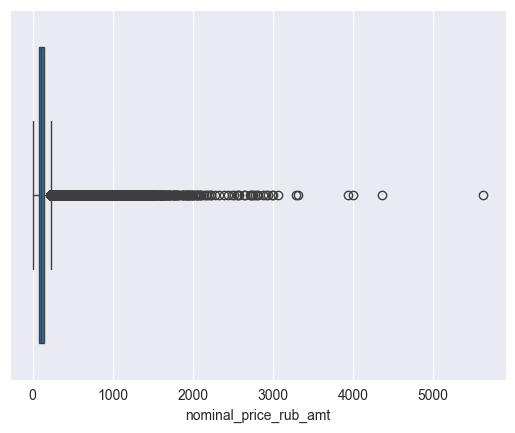

In [14]:
columns_for_clean = ['distance_km', 'nominal_price_rub_amt']
for col in columns_for_clean:
    print(col, end=':')
    sns.boxplot(x = df[col])
    plt.show()

В датасете обнаружены аномальные значения как в колонке `distance_km` (скорее всего из-за сбоя GPS), так и в колонке `nominal_price_rub_amt`.

При очистке важно учитывать редкие, но возможные реальные случаи, чтобы не удалить валидные наблюдения.

Для этого следует ограничить диапазон допустимых значений в соответствии с бизнес-логикой.

distance_km
Распределения:
- среднее: 2.5935617653873386
- медиана: 1.8504900598289349


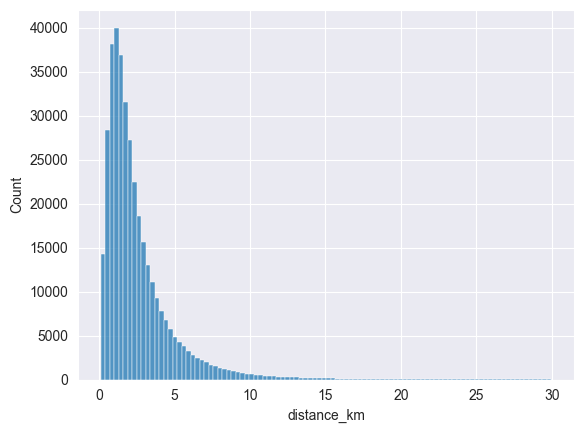

nominal_price_rub_amt
Распределения:
- среднее: 131.43659625630886
- медиана: 105.93


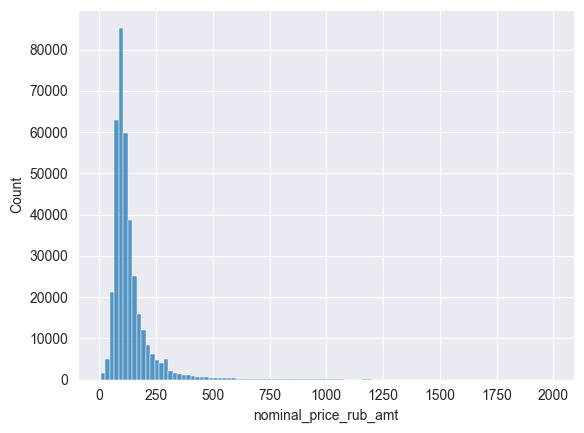

In [15]:
# Состоявшаяся поездка — поездка больше 100 метров
df = df[(df['distance_km'] > 0.1) & (df['distance_km'] < 30) &
    (df['nominal_price_rub_amt'] > 0) & (df['nominal_price_rub_amt'] < 2000)]

columns_after_clean = ['distance_km', 'nominal_price_rub_amt']
for col in columns_after_clean:
    print(f"{col}\nРаспределения:\n- среднее: {df[col].mean()}\n- медиана: {df[col].median()}")
    sns.histplot(df[col], bins=100)
    plt.show()

In [16]:
df.describe()

,order_rk,party_rk,age,minute_cost,activation_cost,hold_amount,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt
count,3.701160e+05,3.701160e+05,370116.000000,370116.000000,370116.000000,370116.000000,370116.000000,370116,370116,370116,370116.000000,370116,370116.000000,370116.000000
mean,2.893846e+08,5.967263e+08,31.542608,7.294218,42.668515,299.999406,2.593562,2024-08-19 00:07:06.438424576,2024-08-19 00:07:12.575507968,2024-08-19 00:19:03.754795520,3.526216,2024-08-19 00:38:46.953487360,131.436596,35.108717
min,2.526112e+08,1.471700e+04,12.000000,1.500000,0.000000,80.000000,0.100033,2024-04-09 12:23:51,2024-04-09 12:23:56.253700,2024-04-09 12:25:18.952234,0.000000,2024-04-09 12:23:56.253700,4.990000,-161.940000
25%,2.618157e+08,2.943334e+08,24.000000,6.490000,30.000000,300.000000,1.084028,2024-07-22 10:18:32,2024-07-22 10:18:36.724357376,2024-07-22 10:33:46.137125120,3.000000,2024-07-22 11:05:44.371917824,84.900000,10.390000
50%,2.704375e+08,6.105246e+08,31.000000,7.490000,50.000000,300.000000,1.850490,2024-08-23 13:51:15,2024-08-23 13:51:19.423956992,2024-08-23 14:03:05.892463360,3.000000,2024-08-23 14:38:48.464513024,105.930000,17.890000
75%,3.432689e+08,8.638580e+08,37.000000,8.220000,50.000000,300.000000,3.188371,2024-09-16 16:50:31.750000128,2024-09-16 16:50:36.559250176,2024-09-16 17:00:47.296203520,3.000000,2024-09-16 17:08:51.769499904,146.200000,33.730000
max,3.562528e+08,1.301075e+09,94.000000,19.990000,50.000000,300.000000,29.980122,2024-10-21 17:18:04,2024-10-21 17:18:07.715000,2024-10-21 17:23:06.640943,12.000000,2024-10-21 21:13:43.199000,1991.570000,2043.890000
std,3.820793e+07,3.307748e+08,9.409417,1.288262,11.970164,0.361621,2.559003,NaN,NaN,NaN,1.197055,NaN,92.029134,65.610775


Удалены нереальные значения, сохранены реальные редкие случаи.

---
## 6. Feature Engineering (Создание новых признаков)
---

In [17]:
# Длительность поездки в минутах
df['trip_duration_min'] = (df['book_end_dttm'] - df['book_start_dttm']).dt.total_seconds() / 60
df.head()

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,trip_duration_min
0,266071307,761067705,M,40,UGR,DIV,ТЮМЕНСКАЯ ОБЛ,4.99,30.0,300.0,SL,3.690479,2024-08-07 09:47:25,2024-08-07 09:47:29.325252,2024-08-07 10:07:59.339524,5,2024-08-07 11:47:29.325252,134.79,19.48,20.500238
1,355113920,614049469,F,30,GRD,MAR,РОСТОВСКАЯ ОБЛ,8.49,50.0,300.0,SL,1.114912,2024-10-17 14:57:20,2024-10-17 14:57:24.586000,2024-10-17 15:04:19.419607,3,2024-10-17 14:57:24.586000,109.43,40.30,6.913893
2,347424551,757583701,M,28,UGR,UNM,СВЕРДЛОВСКАЯ ОБЛ,5.99,30.0,300.0,E,1.515612,2024-09-19 05:31:41,2024-09-19 05:34:59.476000,2024-09-19 05:41:50.164372,5,2024-09-19 07:34:59.476000,71.93,10.79,6.844806
3,351562959,541367366,M,24,GRD,UNM,Г МОСКВА,8.99,50.0,300.0,SL,0.499411,2024-10-04 16:05:09,2024-10-04 16:05:13.162000,2024-10-04 16:07:31.724918,3,2024-10-04 16:05:13.162000,76.97,7.70,2.309382
4,258647149,238473615,M,34,Unknown,Unknown,Г МОСКВА,6.99,50.0,300.0,SL,2.602028,2024-07-10 06:57:40,2024-07-10 06:57:43.017125,2024-07-10 07:07:48.446462,3,2024-07-10 06:57:43.017125,126.89,25.38,10.090489


In [18]:
# Средняя скорость в км/ч
df['avg_speed_kmh'] = df['distance_km'] / df['trip_duration_min'] * 60
df.head()

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,...,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,trip_duration_min,avg_speed_kmh
0,266071307,761067705,M,40,UGR,DIV,ТЮМЕНСКАЯ ОБЛ,4.99,30.0,300.0,...,3.690479,2024-08-07 09:47:25,2024-08-07 09:47:29.325252,2024-08-07 10:07:59.339524,5,2024-08-07 11:47:29.325252,134.79,19.48,20.500238,10.801275
1,355113920,614049469,F,30,GRD,MAR,РОСТОВСКАЯ ОБЛ,8.49,50.0,300.0,...,1.114912,2024-10-17 14:57:20,2024-10-17 14:57:24.586000,2024-10-17 15:04:19.419607,3,2024-10-17 14:57:24.586000,109.43,40.30,6.913893,9.675407
2,347424551,757583701,M,28,UGR,UNM,СВЕРДЛОВСКАЯ ОБЛ,5.99,30.0,300.0,...,1.515612,2024-09-19 05:31:41,2024-09-19 05:34:59.476000,2024-09-19 05:41:50.164372,5,2024-09-19 07:34:59.476000,71.93,10.79,6.844806,13.285504
3,351562959,541367366,M,24,GRD,UNM,Г МОСКВА,8.99,50.0,300.0,...,0.499411,2024-10-04 16:05:09,2024-10-04 16:05:13.162000,2024-10-04 16:07:31.724918,3,2024-10-04 16:05:13.162000,76.97,7.70,2.309382,12.975186
4,258647149,238473615,M,34,Unknown,Unknown,Г МОСКВА,6.99,50.0,300.0,...,2.602028,2024-07-10 06:57:40,2024-07-10 06:57:43.017125,2024-07-10 07:07:48.446462,3,2024-07-10 06:57:43.017125,126.89,25.38,10.090489,15.472164


In [19]:
# Процент выплаченного кэшбэка от стоимости поездки
df['cashback_rate'] = df['loyalty_accrual_rub_amt'] / df['nominal_price_rub_amt']
df.head()

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,...,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,trip_duration_min,avg_speed_kmh,cashback_rate
0,266071307,761067705,M,40,UGR,DIV,ТЮМЕНСКАЯ ОБЛ,4.99,30.0,300.0,...,2024-08-07 09:47:25,2024-08-07 09:47:29.325252,2024-08-07 10:07:59.339524,5,2024-08-07 11:47:29.325252,134.79,19.48,20.500238,10.801275,0.144521
1,355113920,614049469,F,30,GRD,MAR,РОСТОВСКАЯ ОБЛ,8.49,50.0,300.0,...,2024-10-17 14:57:20,2024-10-17 14:57:24.586000,2024-10-17 15:04:19.419607,3,2024-10-17 14:57:24.586000,109.43,40.30,6.913893,9.675407,0.368272
2,347424551,757583701,M,28,UGR,UNM,СВЕРДЛОВСКАЯ ОБЛ,5.99,30.0,300.0,...,2024-09-19 05:31:41,2024-09-19 05:34:59.476000,2024-09-19 05:41:50.164372,5,2024-09-19 07:34:59.476000,71.93,10.79,6.844806,13.285504,0.150007
3,351562959,541367366,M,24,GRD,UNM,Г МОСКВА,8.99,50.0,300.0,...,2024-10-04 16:05:09,2024-10-04 16:05:13.162000,2024-10-04 16:07:31.724918,3,2024-10-04 16:05:13.162000,76.97,7.70,2.309382,12.975186,0.100039
4,258647149,238473615,M,34,Unknown,Unknown,Г МОСКВА,6.99,50.0,300.0,...,2024-07-10 06:57:40,2024-07-10 06:57:43.017125,2024-07-10 07:07:48.446462,3,2024-07-10 06:57:43.017125,126.89,25.38,10.090489,15.472164,0.200016


Необходимо очистить данные на основе новых признаков. Для этого посмотрим на распределение:

trip_duration_min:

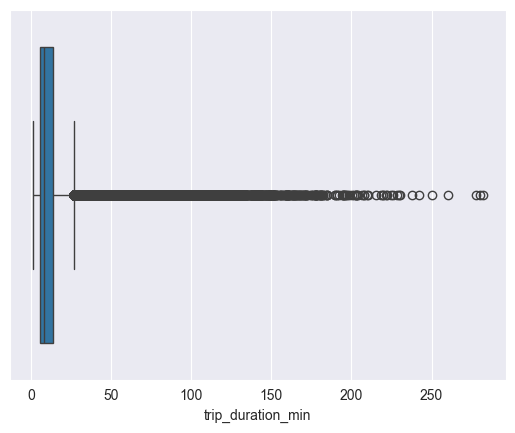

avg_speed_kmh:

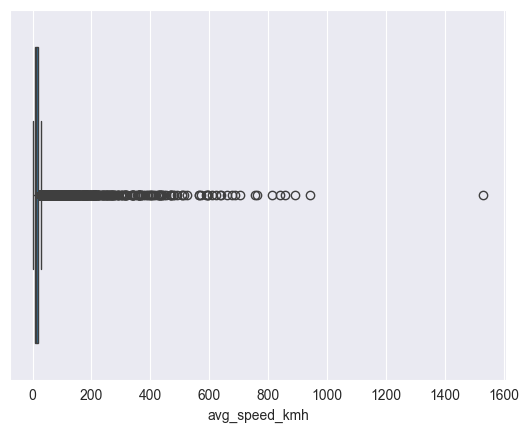

cashback_rate:

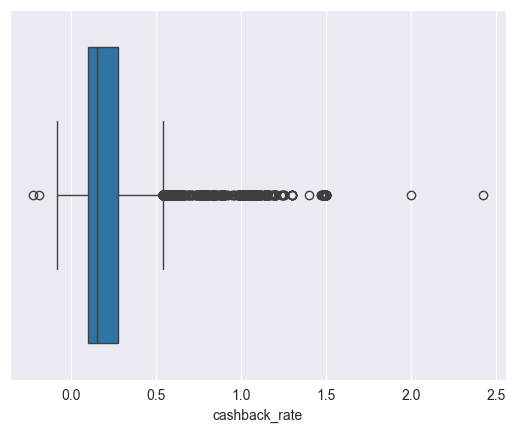

In [20]:
new_columns = ['trip_duration_min', 'avg_speed_kmh', 'cashback_rate']
for col in new_columns:
    print(col, end=':')
    sns.boxplot(x = df[col])
    plt.show()

В каждом из признаков присутствуют аномалии.

In [21]:
df = df[(df['avg_speed_kmh'] > 0) & (df['avg_speed_kmh'] < 30) &
    (df['trip_duration_min'] > 0) & (df['trip_duration_min'] < 180) &
    (df['cashback_rate'] >= 0) & (df['cashback_rate'] <= 1)]

df.head()

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,...,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,trip_duration_min,avg_speed_kmh,cashback_rate
0,266071307,761067705,M,40,UGR,DIV,ТЮМЕНСКАЯ ОБЛ,4.99,30.0,300.0,...,2024-08-07 09:47:25,2024-08-07 09:47:29.325252,2024-08-07 10:07:59.339524,5,2024-08-07 11:47:29.325252,134.79,19.48,20.500238,10.801275,0.144521
1,355113920,614049469,F,30,GRD,MAR,РОСТОВСКАЯ ОБЛ,8.49,50.0,300.0,...,2024-10-17 14:57:20,2024-10-17 14:57:24.586000,2024-10-17 15:04:19.419607,3,2024-10-17 14:57:24.586000,109.43,40.30,6.913893,9.675407,0.368272
2,347424551,757583701,M,28,UGR,UNM,СВЕРДЛОВСКАЯ ОБЛ,5.99,30.0,300.0,...,2024-09-19 05:31:41,2024-09-19 05:34:59.476000,2024-09-19 05:41:50.164372,5,2024-09-19 07:34:59.476000,71.93,10.79,6.844806,13.285504,0.150007
3,351562959,541367366,M,24,GRD,UNM,Г МОСКВА,8.99,50.0,300.0,...,2024-10-04 16:05:09,2024-10-04 16:05:13.162000,2024-10-04 16:07:31.724918,3,2024-10-04 16:05:13.162000,76.97,7.70,2.309382,12.975186,0.100039
4,258647149,238473615,M,34,Unknown,Unknown,Г МОСКВА,6.99,50.0,300.0,...,2024-07-10 06:57:40,2024-07-10 06:57:43.017125,2024-07-10 07:07:48.446462,3,2024-07-10 06:57:43.017125,126.89,25.38,10.090489,15.472164,0.200016


Как избавился от аномалий:
- Ограничил диапазон средней скорости до 30 км/ч, так как скорость выше 30 км/ч — это маловероятно для городских самокатов.
- Ограничил длительность поездки 3 часами, чтобы исключить ошибки отслеживания или незавершенные аренды.
- Кэшбэк не может быть отрицательным или больше 100% в рамках бизнес-выгоды.

distance_km
Распределения:
- среднее: 2.4893681581203846
- медиана: 1.80017905445225


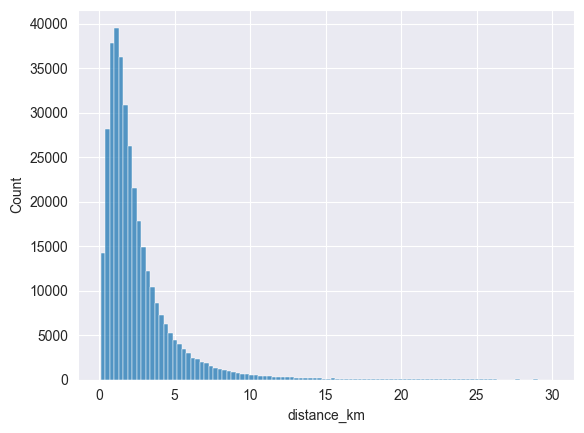

trip_duration_min
Распределения:
- среднее: 11.761824889457394
- медиана: 8.166717716666666


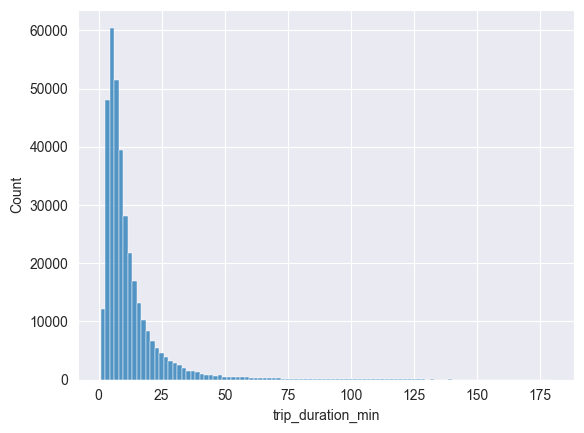

avg_speed_kmh
Распределения:
- среднее: 13.70387444021622
- медиана: 13.107535361237716


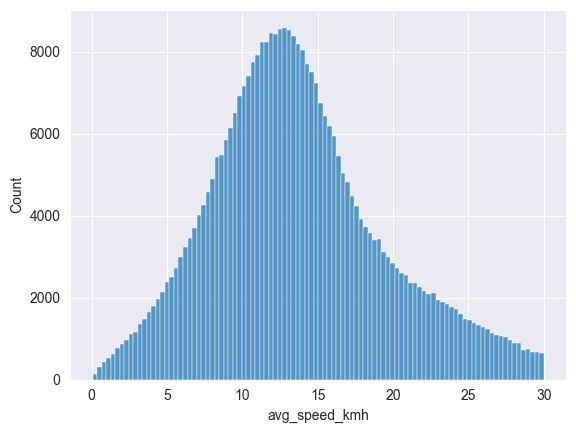

nominal_price_rub_amt
Распределения:
- среднее: 130.6366004950231
- медиана: 105.93


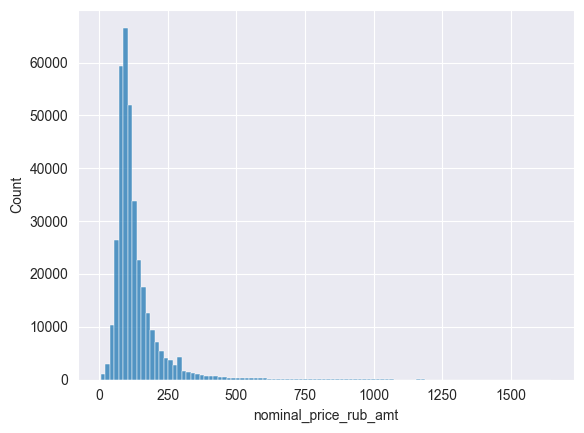

cashback_rate
Распределения:
- среднее: 0.23009101688971345
- медиана: 0.14998978966714316


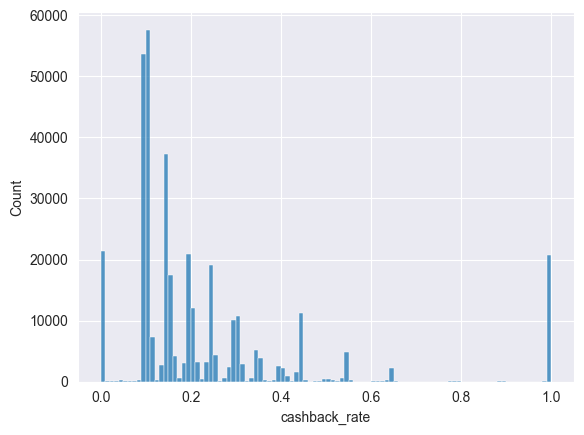

In [22]:
# С учетом всей фильтрации распределение очищенных данных выглядит так

columns_after_clean = ['distance_km', 'trip_duration_min', 'avg_speed_kmh',
                       'nominal_price_rub_amt', 'cashback_rate']
for col in columns_after_clean:
    print(f"{col}\nРаспределения:\n- среднее: {df[col].mean()}\n- медиана: {df[col].median()}")
    sns.histplot(df[col], bins=100)
    plt.show()

In [23]:
print(f"Длина очищенного датасета: {len(df)}")

Длина очищенного датасета: 355943


---
## 9. Сохранение очищенных данных
---

In [24]:
df.to_parquet('../data/cleaned/kicksharing_clean.parquet', index=False)
df.to_csv('../data/cleaned/kicksharing_clean.csv', index=False)

---
## 10. Результаты очистки
---

- Записей в исходном датасете: 396 749
- Записей в датасете после очистки: 355 943
- Изменилось количество колонок (с 20 до 22):
    1. Удалён признак `loyalty_accrual_bns_amt`
    2. Добавлены новые признаки: `trip_duration_min`, `avg_speed_kmh`, `cashback_rate`
- Данные приведены к корректным типам:
    1. даты к datetime
    2. категории к category
- Данные полностью очищены и сохранены в `data/cleaned/kicksharing_clean.csv`. Готовы к исследовательскому анализу (EDA).